<a href="https://colab.research.google.com/github/tintinHL/computer-vision-pipelines/blob/main/test_functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CW_Folder_UG/test_functions.ipynb

# Computer Vision Coursework Submission (IN3060)

**Student name, ID and cohort:** Hoang Long Nguyen Kim (190053092) - UG


# Notebook Setup
In this section you should include all the code cells required to test your coursework submission. Specifically:

### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Define Local Path

In the next cell you should assign to the variable `GOOGLE_DRIVE_PATH_AFTER_MYDRIVE` the relative path of this folder in your Google Drive.

**IMPORTANT:** you have to make sure that **all the files required to test your functions are loaded using this variable** (as was the case for all lab tutorials). In other words, do not use in the notebook any absolute paths. This will ensure that the markers can run your functions. Also, **do not use** the magic command `%cd` to change directory.



In [ ]:
import os

# TODO: Fill in the Google Drive path where you uploaded the lab materials
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Lab materials 01-20210104'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/CW_Folder_UG'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['Personal_Dataset', 'Models', 'Code', 'CW_Dataset', 'test_functions.ipynb']


### Load packages

In the next cell you should load all the packages required to test your functions.

In [ ]:
import cv2
from sklearn.model_selection import train_test_split
from skimage import img_as_ubyte, io, color
from sklearn.cluster import MiniBatchKMeans
from sklearn import svm, metrics
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from skimage import exposure
from joblib import dump, load
from skimage.feature import hog
import torch
from torch.nn.utils.rnn import pad_sequence
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.nn.functional as F
import os, shutil
import random

%matplotlib inline

Unzipping the Dataset file and then organizing the dataset images with folder names corresponding to the label for testing (Following lab 7 and previous model implementations)

In [ ]:
# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset/CV2023_CW_Dataset.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it
!yes|unzip -q CV2023_CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CV2023_CW_Dataset.zip

replace test/images/image_2711.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/images/image_2654.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/images/image_2438.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/images/image_2592.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/images/image_2746.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/images/image_2603.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/images/image_2480.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/images/image_2750.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/images/image_2615.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/images/image_2496.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/images/image_2479.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/images/image_2707.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/images/image_2642.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/images/image

In [ ]:
# loading files taken from https://stackoverflow.com/questions/273192/how-can-i-safely-create-a-directory-possibly-including-intermediate-directories
from pathlib import Path

def dataFolder(trainImagePath, testImagePath):
  Path("./Data").mkdir(parents=True, exist_ok=True)
  Path("./Data/train").mkdir(parents=True, exist_ok=True)
  Path("./Data/test").mkdir(parents=True, exist_ok=True)

  # Creating folders for all labels (0-not wearing mask, 1-wearing mask properly, 2- wearing mask inproperly)
  for n in range(3):
    Path(f"./Data/train/{n}").mkdir(parents=True, exist_ok=True)
    Path(f"./Data/test/{n}").mkdir(parents=True, exist_ok=True)

  # Initialisng train and test path
  trainPath = './Data/train'
  testPath = './Data/test'

 # Reading the text file names and the number within the text file in train folder to match with the name of the image
  file_names = [file for file in os.listdir(trainImagePath) if file.endswith('.jpeg')]
  # print(file_names)
  label_files = os.listdir('./train/labels')
  parsed_data = {x.removesuffix(".txt") + ".jpeg":open('./train/labels/' + x, "r").read().strip() for x in label_files}
  # Putting the images into assigned folders for train folder
  for file in file_names:
    shutil.copy(f"{trainImagePath}/{file}", f"{trainPath}/{parsed_data[file.replace('_aligned', '')]}/{file}")

 # Reading the text file names and the number within the text file in test folder to match with the name of the image
  file_names = [file for file in os.listdir(testImagePath) if file.endswith('.jpeg')]
  label_files = os.listdir('./test/labels')
  parsed_data = {x.removesuffix(".txt") + ".jpeg":open('./test/labels/' + x, "r").read().strip() for x in label_files}
  # Putting the images into assigned folders for test folder
  for file in file_names:
    shutil.copy(f"{testImagePath}/{file}", f"{testPath}/{parsed_data[file.replace('_aligned', '')]}/{file}")

In [ ]:
# Loading the folders
dataFolder('./train/images', './test/images')

In [ ]:
# Defining a function to load images and the respective labels, also allowing the subset of classes (From lab 7)

def import_selected_data(path, label_list):
    images = []
    labels = []

    if label_list is None:
        folder_names = [folder for folder in sorted(os.listdir(path)) if not folder.startswith('.')]
    else:
        print(path)
        print(os.listdir(path))
        folder_names = [folder for folder in sorted(os.listdir(path)) if folder in label_list]

    for folder in folder_names:
        file_names = [file for file in sorted(os.listdir(os.path.join(path, folder))) if file.endswith('.jpeg')]
        for file in file_names:
            images.append(io.imread(os.path.join(path, folder, file)))
            labels.append(folder)

    return images, labels

Fixing the data for SIFT_SVM and SIFT_MLP models (from previous implementations and mainly lab 7)

In [ ]:
def siftImages(images, labels):

  X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, shuffle=True, stratify=labels)

  # Initiate SIFT detector
  sift = cv2.SIFT_create()

  # Create empty lists for feature descriptors and labels
  des_list_test = []
  y_test_list = []

  # Identify keypoints and extract descriptors with SIFT
  for i in range(len(X_train)):
    img = img_as_ubyte(color.rgb2gray(X_train[i]))
    kp, des = sift.detectAndCompute(img, None)


    # Append list of descriptors and label to respective lists
    if des is not None:
      # print('des', des.shape)
      # break

      des_list_test.append(des)
      y_test_list.append(y_train[i])

  # Convert to array for easier handling
  des_array = np.vstack(des_list_test)


# Number of centroids/codewords: good rule of thumb is 10*num_classes
  k = len(np.unique(y_train)) * 10

# Use MiniBatchKMeans for faster computation and lower memory usage
  batch_size = des_array.shape[0] // 4
  kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size).fit(des_array)


  hist_list = []
  idx_list = []

  for des in des_list_test:
    hist = np.zeros(k)

    idx = kmeans.predict(des)
    idx_list.append(idx)
    for j in idx:
        hist[j] = hist[j] + (1 / len(des))
    hist_list.append(hist)

  hist_array = np.vstack(hist_list)

  return hist_array, y_test_list


Function to plot ground truth data and predicted labels (from previous implementations and lab 7)

In [ ]:
def plotGroundTruth(images, labels, pred):
  fig, axes = plt.subplots(1, 4, figsize=(14, 7), sharex=True, sharey=True)
  ax = axes.ravel()

  # Prints random 4 images from the dataset and it's prediction and label with image number
  import random
  for index, i in enumerate([random.randint(0, len(pred)) for _ in range(4)]):

      ax[index].imshow(images[i])
      ax[index].set_title(f'Label: {labels[i]} \n Prediction: {pred[i]} \n Image #{i}')
      ax[index].set_axis_off()
  fig.tight_layout()
  plt.show()

Fixing the data for HOG_SVM and HOG_MLP (From lab 6 and 7 and previous HOG implementations)




In [ ]:
def extract_hog_features(image):
    # Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Compute HOG features
    features, hog_image = hog(gray_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, multichannel=False)

    return features, hog_image

In [ ]:
# Data loader function
def load_images_from_folder(folder):
    # Initialize lists for storing images and labels
    images = []
    labels = []
    original_images = []
    # Loop through each subfolder in the folder
    for subfolder in os.listdir(folder):
        subfolder_path = os.path.join(folder, subfolder)
        # Loop through each image in the subfolder
        for filename in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, filename)
            # Load image
            img = cv2.imread(img_path)

            # Extract HOG features
            hog_features, hog_image = extract_hog_features(img)
            # Add image and label to the lists
            images.append(torch.tensor(hog_features))
            labels.append(int(subfolder))
            original_images.append(img)

    # # convert to array
    original_images = np.array(original_images)
    # Padding using pytorch pad sequence
    padded_tensors = pad_sequence(images,batch_first=True, padding_value=0)
    # hog_images = np.array(hog_images, dtype=object)
    padded_numpy_array = padded_tensors.numpy()
    return padded_numpy_array , labels, original_images

In [ ]:
# Load training data
train_folder = 'Data/train'
train_images, train_labels, train_original_images= load_images_from_folder(train_folder)

# Load testing data
test_folder = 'Data/test'
test_images, test_labels, test_original_images = load_images_from_folder(test_folder)

<ipython-input-168-08e3e4c073ac>:5: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  features, hog_image = hog(gray_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, multichannel=False)
<ipython-input-169-77f530fc5aad>:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  original_images = np.array(original_images)


In [ ]:
# get four random images
def getFourRandomImages(folder):
    # Initialize lists for storing images and labels
    images = []
    labels = []
    original_images = []
    # Loop through each subfolder in the folder
    for subfolder in os.listdir(folder):
        subfolder_path = os.path.join(folder, subfolder)
        # Loop through each image in the subfolder
        for filename in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, filename)
            # Load image
            img = cv2.imread(img_path)

            # Extract HOG features
            hog_features, hog_image = extract_hog_features(img)
            # Add image and label to the lists
            images.append(torch.tensor(hog_features))
            labels.append(int(subfolder))
            original_images.append(img)

    # Select four random images from the list of all images
    num_images = 4
    if len(images) > num_images:
        selected_indices = random.sample(range(len(images)), num_images)
        images = [images[i] for i in selected_indices]
        labels = [labels[i] for i in selected_indices]
        original_images = [original_images[i] for i in selected_indices]

    # Convert original_images list to numpy array
    original_images = np.array(original_images)
    # Padding using pytorch pad sequence
    padded_tensors = pad_sequence(images, batch_first=True, padding_value=0)
    padded_numpy_array = padded_tensors.numpy()

    # reshape to match feature
    num_features = 56088

    # reshape the test set to match the number of features in the training set
    test_images_reshaped = np.zeros((padded_numpy_array.shape[0], num_features))
    test_images_reshaped[:, :padded_numpy_array.shape[1]] = padded_numpy_array
    return test_images_reshaped, labels, original_images

In [ ]:
# function to convert labels to category
def labelMapping(label):
  if label == 0:
    return  'No Mask'
  elif label == 1:
    return 'Mask'
  else:
    return 'Not Proper Mask'

In [ ]:
import cv2
import matplotlib.pyplot as plt

def display_images(images, labels, predictions, size=(256, 256)):
    new_labels = []
    new_pred = []
    # label encoding
    for i in range(len(labels)):
      new_labels.append(labelMapping(labels[i]))
      new_pred.append(labelMapping(labels[i]))
    # Create a grid of 1 row and 4 columns
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))

    # Resize and convert images to RGB format
    resized_images = []
    for img in images:
        resized_img = cv2.resize(img, size)
        rgb_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)

        # Perform histogram equalization on the image
        hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
        hsv_img[:,:,2] = cv2.equalizeHist(hsv_img[:,:,2])
        equalized_img = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)

        resized_images.append(equalized_img)

    # Plot the images using matplotlib
    for i, ax in enumerate(axes):
        # Display label and prediction on top of each image
        ax.set_title(f"Label: {new_labels[i]}\nPrediction: {new_pred[i]}")
        ax.imshow(resized_images[i])
        ax.axis('off')

    plt.show()

Fixing the PyTorch data so tests can be run (from CNN implementation and lab 8 and 9)

In [ ]:
# Implementing CNN
class ConvolutionalNeuralNetwork(nn.Module):
  def __init__(self):
        # Initializing the base class
        super(ConvolutionalNeuralNetwork, self).__init__()
        # Defining the 4 convolutional layers and 2x2 Max-Pooling
        # 3 input image channel, 12 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3,12,3)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(12, 48, 3)
        self.conv3 = nn.Conv2d(48, 192,3)
        self.conv4 = nn.Conv2d(192, 768, 3)
        # Creating connected layers with nn.Linear(input size, output size)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(768*12*12, 140) # 12*12 from image dimension
        self.fc2 = nn.Linear(140,98)
        self.fc3 = nn.Linear(98,3) # As we got 3 labels

  # Forward pass implementation
  def forward(self, x):
      #Applying first convolutional layer followed by activation function (ReLU) and then pooling
      x = self.pool(F.relu(self.conv1(x)))
      #Applying second convolutional layer followed by activation function (ReLU) and then pooling
      x = self.pool(F.relu(self.conv2(x)))
      #Applying third convolutional layer followed by activation function (ReLU) and then pooling
      x = self.pool(F.relu(self.conv3(x)))
      #Applying fourth convolutional layer followed by activation function (ReLU) and then pooling
      x = self.pool(F.relu(self.conv4(x)))

      # Flattening the view to pass the fully connected layers
      x = x.view(-1, 110592) #As it's 768*12*12 from the first layer

      # Applying ReLU and fully connected layers
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))

      x = self.fc3(x)
      return x

In [ ]:
cnn = ConvolutionalNeuralNetwork()

Function for loading and data transformation (From lab 9)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_dir = 'Data'
# Lists with the means and standard deviations
data_means = [0.485, 0.456, 0.406]
data_stds = [0.229, 0.224, 0.225]

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
def transform_Data(path):
  data_transforms = {
      'test': transforms.Compose([
          transforms.Resize(256),
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          transforms.Normalize(data_means, data_stds)
      ]),
  }
  image_datasets = {x: datasets.ImageFolder(os.path.join(path, x),
                                          data_transforms[x])
                  for x in ['test']}
  dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['test']}
  class_names = image_datasets['test'].classes

  return dataloaders, class_names

Function to display the ground truth tables with image and prediction (From lab 9)

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.asarray(data_stds) * inp + np.asarray(data_means)
    inp = np.clip(inp, 0, 1)       # Clip to intensity outliers to [0, 1] range
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

def visualize_model(model,dataloaders, class_names, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(1, num_images, images_so_far)
                ax.axis('off')
                ax.set_title(f"Predicted: {class_names[preds[j]]} \n Label: {class_names[labels[j]]}")
                imshow(inputs.cpu().data[j])        # move back the data to the CPU for visualisation

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Load models

In the next cell you should load all your trained models for easier testing of your functions. Avoid to load them within `MaskDetection` to avoid having to reload them each time.

In [ ]:
#Example
#hog-svm = load(os.path.join(GOOGLE_DRIVE_PATH, 'Models','hog-svm.joblib'))

sift_svm = load(os.path.join(GOOGLE_DRIVE_PATH, 'Models', 'SIFT_SVM.joblib'))
sift_mlp = load(os.path.join(GOOGLE_DRIVE_PATH, 'Models', 'SIFT_MLP.joblib'))
hog_svm = load(os.path.join(GOOGLE_DRIVE_PATH, 'Models','HOG_SVM.joblib'))
hog_mlp = load(os.path.join(GOOGLE_DRIVE_PATH, 'Models','HOG_MLP.joblib'))
cnn = torch.load((os.path.join(GOOGLE_DRIVE_PATH, 'Models/CNN.pth')), map_location=torch.device('cpu'))

# Test MaskDetection

This section should allow a quick test of the `MaskDetection` function. First, add cells with the code needed to load the necessary subroutines to make `MaskDetection` work.

In [ ]:
from random import shuffle
def MaskDetection(path_to_testset, model_type):

  # The following models can be selected: sift_svm, sift_mlp, cnn
  if(model_type == "sift_svm"):
    print("SIFT_SVM")
    X, y = import_selected_data(path_to_testset+'/test', label_list=['0', '1', '2'])
    hist_array, y_test_list = siftImages(X, y)
    sift_svm.fit(hist_array, y_test_list)
    y_pred = sift_svm.predict(hist_array)
    plotGroundTruth(X,y,y_pred)
  elif(model_type == "sift_mlp"):
    print("SIFT_MLP")
    X, y = import_selected_data(path_to_testset+'/test', label_list=['0', '1', '2'])
    hist_array, y_test_list = siftImages(X, y)
    sift_svm.fit(hist_array, y_test_list)
    y_pred = sift_svm.predict(hist_array)
    plotGroundTruth(X,y,y_pred)
  elif(model_type == "hog_svm"):
    print("HOG_SVM")
    images, labels, original_images= getFourRandomImages(path_to_testset+'/test')
    pred = hog_svm.predict(images)
    display_images(original_images, labels, pred)
  elif(model_type == "hog_mlp"):
    print("HOG_MLP")
    images, labels, original_images= getFourRandomImages(path_to_testset+'/test')
    pred = hog_mlp.predict(images)
    display_images(original_images, labels, pred)
  elif(model_type == "cnn"):
    print("CNN")
    DataLoader, classNames = transform_Data(path_to_testset)
    cnn.eval()
    visualize_model(cnn, DataLoader, classNames)
  else:
    print("Please enter a valid model")

Then, make a call to the `MaskDetection` function to see what results it produces. You must also indicate the syntax needed to test your different models.

CNN


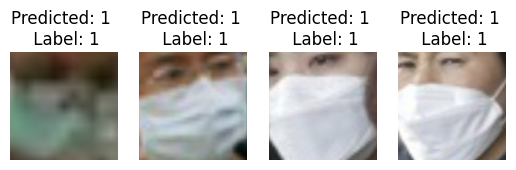

In [ ]:
# Syntax for the next function is the following:
#
# MaskDetection(path_to_testset, model_type)
#
# where model_type can be one of
#   - sift_svm
#   - sift_mlp
#   - hog_svm
#   - hog_mlp
#   - cnn

path_to_testset = 'Data'
MaskDetection(path_to_testset, 'cnn')

# Test MaskDetection in the wild

This section should allow a quick test of the `MaskDetection` on your `Personal_Dataset`.

CNN


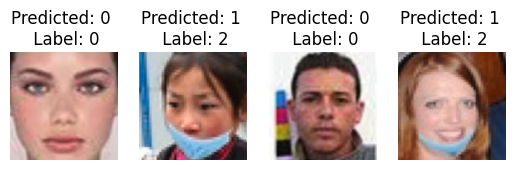

In [ ]:
# Syntax for the next function is the following:
#
# MaskDetection(path_to_testset, model_type)
#
# where model_type can be one of
#   - sift_svm
#   - sift_mlp
#   - hog_svm
#   - hog_mlp
#   - cnn
path_to_testset = os.path.join(GOOGLE_DRIVE_PATH, 'Personal_Dataset')
MaskDetection(path_to_testset, 'cnn')